In [14]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from stable_baselines3 import PPO,SAC,TD3
matplotlib.use('Agg')
import datetime

from finrl import config
from finrl import config_tickers
from finrl.finrl_meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_portfolio_allocation.env_portfolio import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
from finrl.finrl_meta.data_processor import DataProcessor
from finrl.finrl_meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys
import random
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv
from scipy import stats
from environment import StockPortfolioEnv
import os

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

BONDS = ['^IRX','^FVX','^TNX','^TYX']
ETF = ['CAPD','QLD','EZA','KBA','FBZ','IEUS']

tickers = config_tickers.DOW_30_TICKER

INITIAL_DATE = '2020-01-01'
FINAL_DATE = '2022-06-10'

df = YahooDownloader(start_date = INITIAL_DATE,
                     end_date = FINAL_DATE,
                     ticker_list = tickers).fetch_data()

fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=True,
                    user_defined_feature = False)

df = fe.preprocess_data(df)




#df = pd.read_csv('./dow30.csv')
print(df)
df_original = df.copy()

# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values 
  cov_list.append(covs)

  
df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

if('turbulence' not in config.INDICATORS):
    config.INDICATORS.append('turbulence')
config.INDICATORS

df_tech = df[config.INDICATORS]
df_tech = (df_tech - df_tech.expanding().min())/(df_tech.expanding().max() - df_tech.expanding().min())
df_tech = df_tech.fillna(0.5)

for col in df_tech.columns:
    df[col] = df_tech[col]

from scipy import stats
trade = data_split(df,'2019-01-02', '2022-06-10')
stock_dimension = len(trade.tic.unique())
act_space = stock_dimension + 1
state_space = stock_dimension
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS,
    "turbulence_threshold":0.1, 
    "action_space": act_space, 
    "reward_scaling": 1e-4,
    "training":False
    
}

trained_ppo = PPO.load('./trained_ppo.zip')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)
df_daily_return_ppo, df_actions_ppo = DRLAgent.DRL_prediction(model=trained_ppo,
                        environment = e_trade_gym)
trained_td3 = TD3.load('./td3.zip')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)
df_daily_return_td3, df_actions_td3 = DRLAgent.DRL_prediction(model=trained_td3,
                        environment = e_trade_gym)

trained_sac = SAC.load('./sac.zip')
e_trade_gym = StockPortfolioEnv(df = trade, **env_kwargs)
df_daily_return_sac, df_actions_sac = DRLAgent.DRL_prediction(model=trained_sac,
                        environment = e_trade_gym)

[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


[*********************100%***********************]  1 of 1 completed


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)


Shape of DataFrame:  (20944, 8)


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  indicator_df = indicator_df.append(
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/preprocessors.py:154: FutureWarning: The frame.append method is deprecated an

Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return arguments after parsing column name: 'turbulence'
Invalid number of return 

KeyError: "None of [Index(['tic', 'date', 'turbulence'], dtype='object')] are in the [columns]"

In [ ]:
from pyfolio import timeseries
DRL_strat_ppo = convert_daily_return_to_pyfolio_ts(df_daily_return_ppo)
perf_func = timeseries.perf_stats 
perf_stats_all_ppo = perf_func( returns=DRL_strat_ppo, 
                              factor_returns=DRL_strat_ppo, 
                                positions=None, transactions=None, turnover_denom="AGB")

/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [ ]:
print("==============PPO Strategy Stats===========")
perf_stats_all_ppo

==============DRL Strategy Stats===========


Annual return           0.096354
Cumulative returns      0.372304
Annual volatility       0.142228
Sharpe ratio            0.717996
Calmar ratio            0.556602
Stability               0.899482
Max drawdown           -0.173112
Omega ratio             1.150997
Sortino ratio           1.030143
Skew                   -0.136302
Kurtosis               10.219185
Tail ratio              0.936516
Daily value at risk    -0.017514
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [ ]:
DRL_strat_td3 = convert_daily_return_to_pyfolio_ts(df_daily_return_td3)
perf_func = timeseries.perf_stats 
perf_stats_all_td3 = perf_func( returns=DRL_strat_td3, 
                              factor_returns=DRL_strat_td3, 
                                positions=None, transactions=None, turnover_denom="AGB")

/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [ ]:
print("==============TD3 Strategy Stats===========")
perf_stats_all_td3

==============DRL Strategy Stats===========


Annual return           0.134476
Cumulative returns      0.543554
Annual volatility       0.226375
Sharpe ratio            0.671039
Calmar ratio            0.393667
Stability               0.851295
Max drawdown           -0.341598
Omega ratio             1.150359
Sortino ratio           0.941550
Skew                   -0.287391
Kurtosis               18.936994
Tail ratio              0.842342
Daily value at risk    -0.027918
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [ ]:
DRL_strat_sac = convert_daily_return_to_pyfolio_ts(df_daily_return_sac)
perf_func = timeseries.perf_stats 
perf_stats_all_sac = perf_func( returns=DRL_strat_sac, 
                              factor_returns=DRL_strat_sac, 
                                positions=None, transactions=None, turnover_denom="AGB")

/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


In [ ]:
print("==============SAC Strategy Stats===========")
perf_stats_all_td3

==============SAC Strategy Stats===========


Annual return           0.134476
Cumulative returns      0.543554
Annual volatility       0.226375
Sharpe ratio            0.671039
Calmar ratio            0.393667
Stability               0.851295
Max drawdown           -0.341598
Omega ratio             1.150359
Sortino ratio           0.941550
Skew                   -0.287391
Kurtosis               18.936994
Tail ratio              0.842342
Daily value at risk    -0.027918
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [21]:
df_actions_ppo.tail(1).describe()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,VZ,WBA,WMT,CASH
count,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.0,...,1.0,1.0,1.000000,1.0,1.000000,1.000000,1.0,1.0,1.00000,1.000000
mean,0.0,0.0,0.0,0.0,0.058885,0.0,0.022202,0.0,0.041559,0.0,...,0.0,0.0,0.032058,0.0,0.115051,0.152775,0.0,0.0,0.00414,0.483722
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.0,0.0,0.0,0.0,0.058885,0.0,0.022202,0.0,0.041559,0.0,...,0.0,0.0,0.032058,0.0,0.115051,0.152775,0.0,0.0,0.00414,0.483722
25%,0.0,0.0,0.0,0.0,0.058885,0.0,0.022202,0.0,0.041559,0.0,...,0.0,0.0,0.032058,0.0,0.115051,0.152775,0.0,0.0,0.00414,0.483722
50%,0.0,0.0,0.0,0.0,0.058885,0.0,0.022202,0.0,0.041559,0.0,...,0.0,0.0,0.032058,0.0,0.115051,0.152775,0.0,0.0,0.00414,0.483722
75%,0.0,0.0,0.0,0.0,0.058885,0.0,0.022202,0.0,0.041559,0.0,...,0.0,0.0,0.032058,0.0,0.115051,0.152775,0.0,0.0,0.00414,0.483722
max,0.0,0.0,0.0,0.0,0.058885,0.0,0.022202,0.0,0.041559,0.0,...,0.0,0.0,0.032058,0.0,0.115051,0.152775,0.0,0.0,0.00414,0.483722


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (867, 8)


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/finrl/finrl_meta/preprocessor/yahoodownloader.py:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_df = data_df.append(temp_df)
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2019-01-02
End date,2022-06-09
Total months,41
,Backtest
Annual return,9.635%
Cumulative returns,37.23%
Annual volatility,14.223%
Sharpe ratio,0.72
Calmar ratio,0.56
Stability,0.90
Max drawdown,-17.311%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.31,2020-02-13,2020-03-23,2020-05-11,63
1,10.79,2020-09-02,2020-10-28,2020-11-16,54
2,7.34,2022-03-30,2022-05-20,NaT,NaN
3,5.23,2020-06-08,2020-06-11,2020-07-01,18
4,5.06,2021-11-08,2021-12-01,2022-01-04,42


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' i

Stress Events,mean,min,max
New Normal,0.04%,-6.54%,6.37%


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


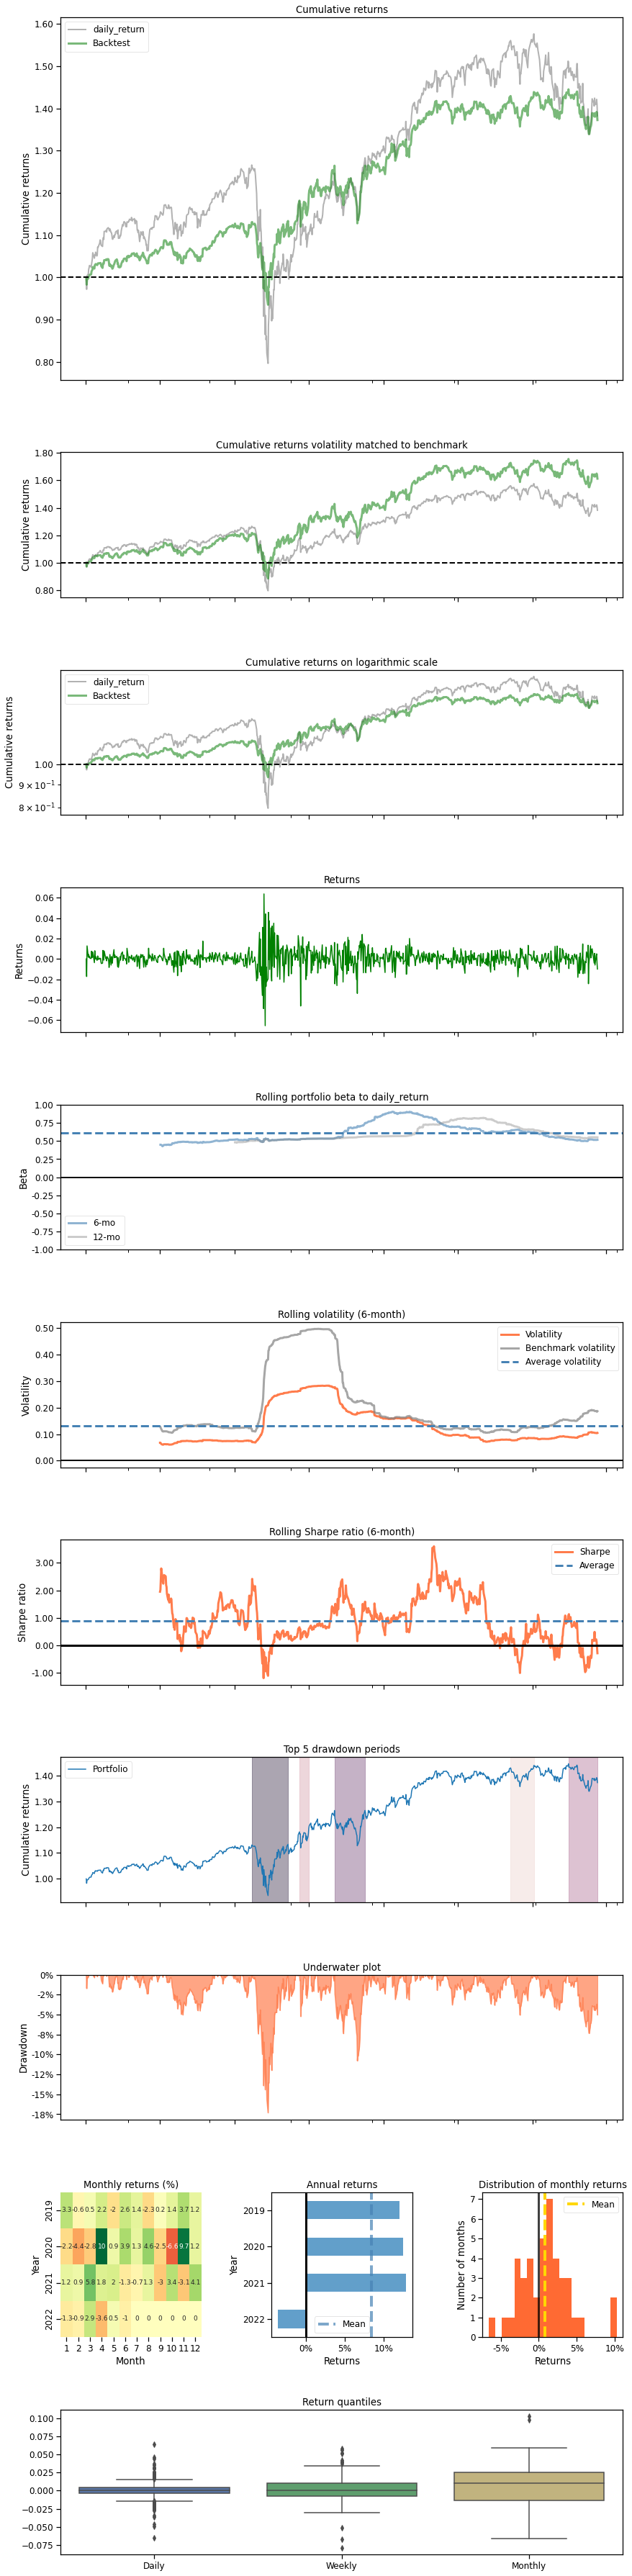

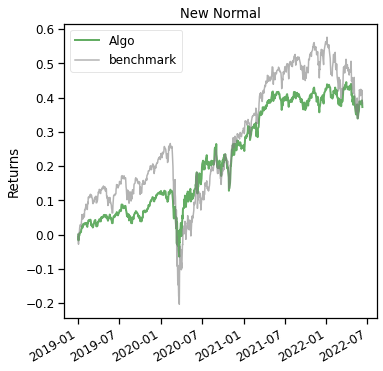

In [ ]:
import pyfolio
%matplotlib inline

baseline_df = get_baseline(
        ticker='^DJI', start=df_daily_return_ppo.loc[0,'date'], end='2022-06-10'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat_ppo,
                                       benchmark_rets=baseline_returns, set_context=False)

/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2019-01-02
End date,2022-06-09
Total months,41
,Backtest
Annual return,13.448%
Cumulative returns,54.355%
Annual volatility,22.637%
Sharpe ratio,0.67
Calmar ratio,0.39
Stability,0.85
Max drawdown,-34.16%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.16,2020-02-14,2020-03-23,2020-08-28,141
1,13.93,2022-01-12,2022-05-20,NaT,NaN
2,10.45,2020-09-02,2020-10-28,2020-11-16,54
3,7.52,2019-04-23,2019-05-31,2019-06-20,43
4,4.68,2019-07-30,2019-08-05,2019-09-05,28


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' i

Stress Events,mean,min,max
New Normal,0.06%,-11.74%,11.59%


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


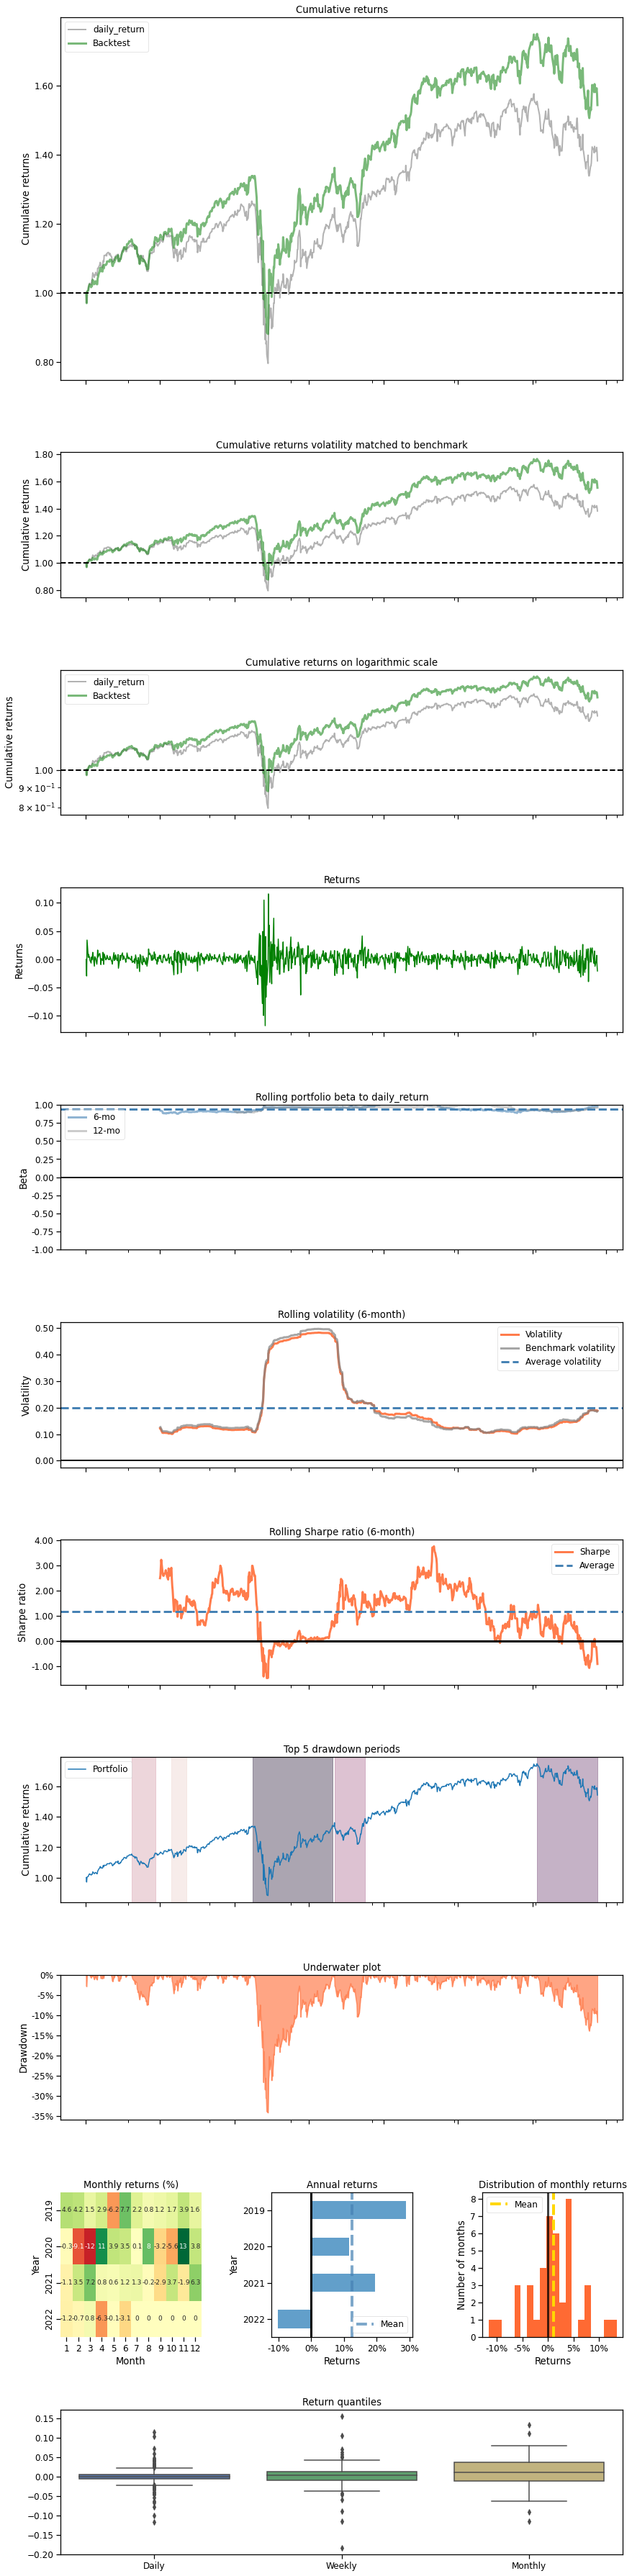

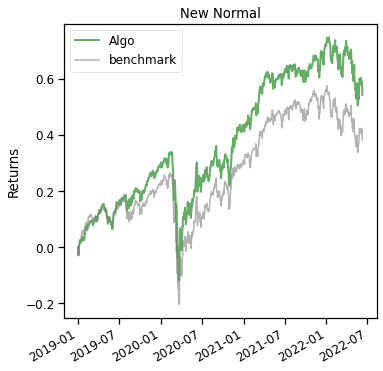

In [ ]:
baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat_td3,
                                       benchmark_rets=baseline_returns, set_context=False)

/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2019-01-02
End date,2022-06-09
Total months,41
,Backtest
Annual return,15.11%
Cumulative returns,62.28%
Annual volatility,21.472%
Sharpe ratio,0.76
Calmar ratio,0.50
Stability,0.86
Max drawdown,-30.373%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.37,2020-02-12,2020-03-23,2020-06-08,84
1,15.33,2022-01-04,2022-05-19,NaT,NaN
2,9.82,2020-06-08,2020-06-11,2020-09-02,63
3,9.12,2020-09-02,2020-10-28,2020-11-09,49
4,6.12,2019-04-30,2019-05-31,2019-06-19,37


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' i

Stress Events,mean,min,max
New Normal,0.07%,-11.02%,9.92%


/Users/simone/opt/anaconda3/lib/python3.9/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


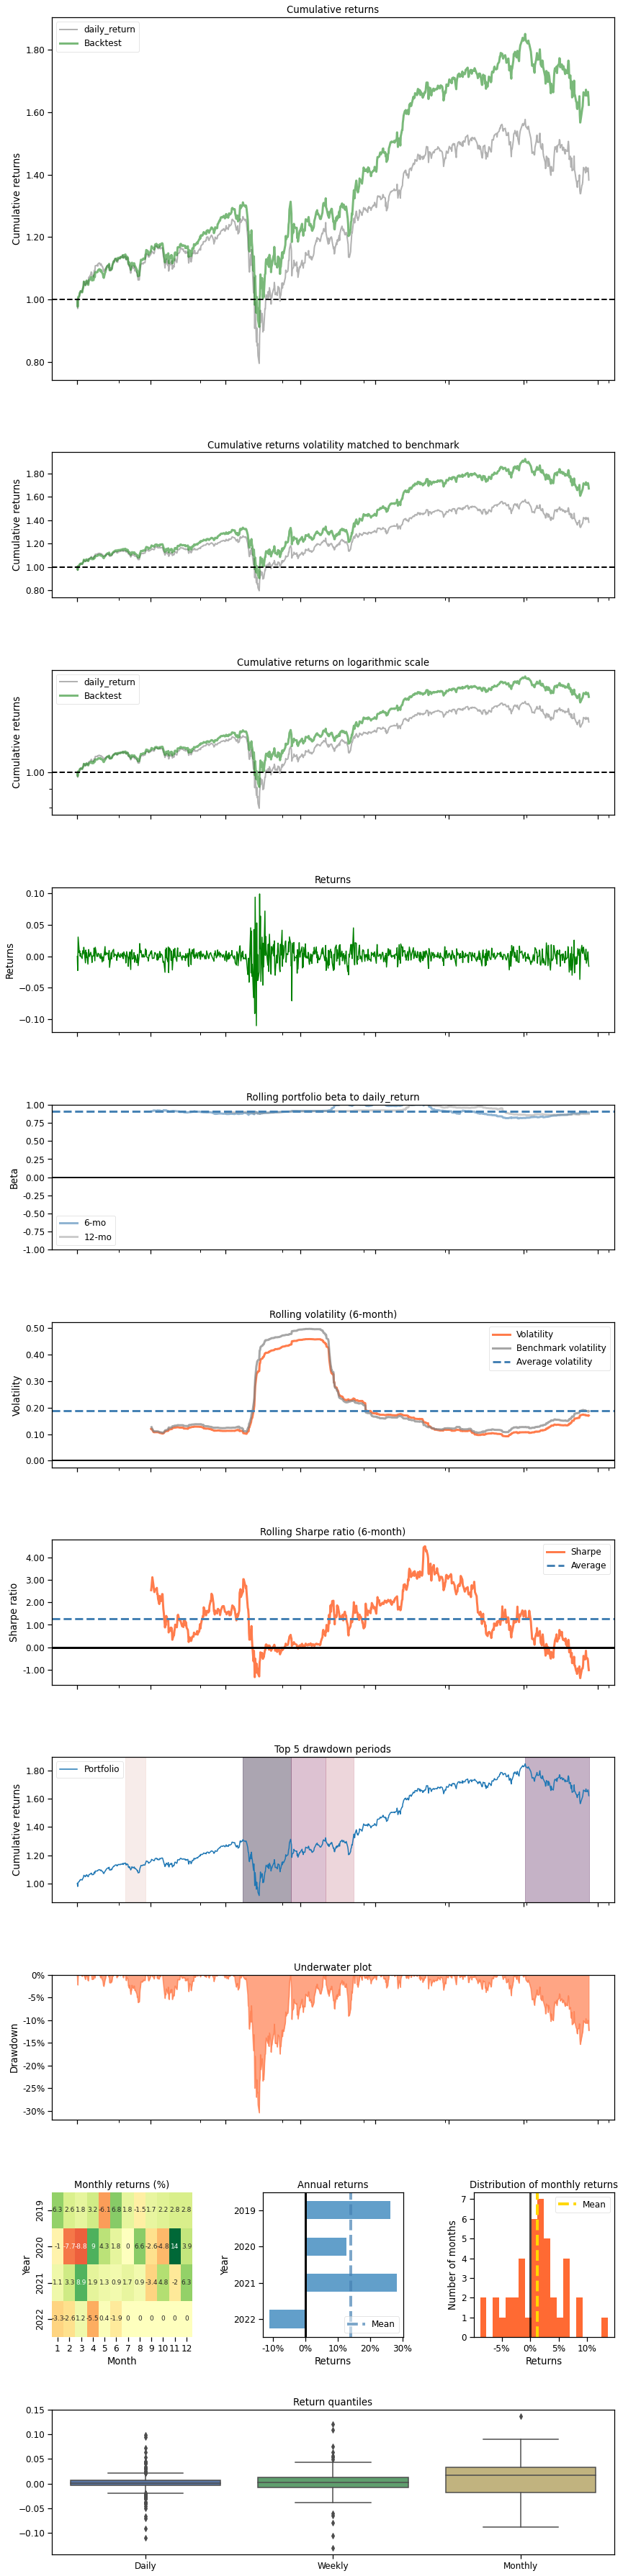

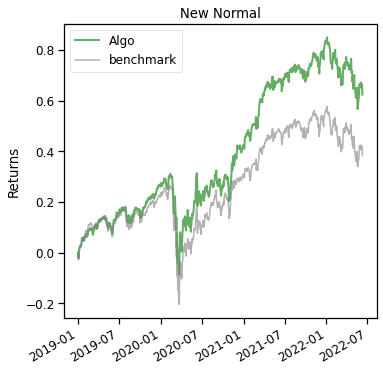

In [ ]:
baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat_sac,
                                       benchmark_rets=baseline_returns, set_context=False)